In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# import other functions
from imputer import *
from feature_eng import *
from drop import *

## Summary

|Model| Test MAE| Test MSE|
|-----|---------|---------|
| Simple LR | 99.675 | 190.922| 
| Ridge regression| 99.631 |190.895|
| Simple LGBM | 53.161 | 110.994 |
| LGBM with gridsearch | 
| LGBM with log transformed y | 51.2 | NA |


**Comments -** 


In [2]:
df = pd.read_csv("../data/train_data.zip")

In [3]:
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,1804425,8,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,244.20,0.157475,0.009783,0.147692
1,1812706,2,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
2,1812706,3,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
3,1812706,11,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,24.0,258.95,0.157475,0.009783,0.147692
4,1812706,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,258.95,0.157475,0.009783,0.147692


## Pre-processing data

In [4]:
# drop rows missing target variable
df = drop_missing_unacast(df)

# create X and y
X = df.drop(columns = ['unacast_session_count'], axis=1)
y = df.loc[:, 'unacast_session_count']
# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2,
                                                      random_state=2020)
# impute NaN values
result = impute_data(X_train, X_valid)
X_train = result[0]
X_valid = result[1] 
# perform feature eng
X_train = comb_cols(X_train)
X_valid = comb_cols(X_valid)
# perform dropping
X_train = drop_columns(X_train)
X_valid = drop_columns(X_valid)

# perform OHE (climate, density_class, income_class)
X_train_valid = clean_categorical(X_train, X_valid)
X_train = X_train_valid[0]
X_valid = X_train_valid[1]

In [5]:
def show_scores(model, X, y, error = 'mse'):
    """
    Shows the mean squared error and mean absolute error for a given model
    and predictors and response
    
    Parameters
    ----------
    model: The sklearn model object
    X: numpy.ndarray        
        The predictors(independent variables) part of the data
    y: numpy.ndarray
        The response(target variable)of the data
    error: string,
        'mse' or 'mae' depending upon the type of error
        we are interested in
        
    Returns
    ------- 
    """            
    y_preds = model.predict(X)
    
    if error == 'mse':
        rmse = mean_squared_error(y, y_preds, squared = False)
        print("Root mean squared error: %0.3f" % rmse)
        return
    if error == 'mae':
        mae = mean_absolute_error(y, y_preds)
        print("Mean absolute error: %0.3f" % mae)
        return
    else:
        print("Wrong choice")

## Modelling with Linear regression

In [9]:
cols_sum = np.sum(X_train, axis = 0)
cols_sum[cols_sum ==0]

monthly_rain               0.0
monthly_avg_rain_length    0.0
dtype: float64

In [6]:
print(X_train.shape)
print(X_valid.shape)

(39592, 632)
(9898, 632)


### 1. Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mse')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mse')

Simple linear regression scores: 
Train error: 
Root mean squared error: 182.973
Test error: 
Root mean squared error: 190.922


In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mae')

Simple linear regression scores: 
Train error: 
Mean absolute error: 96.979
Test error: 
Mean absolute error: 99.675


In [16]:
y_pred = lr.predict(X_valid)
y_pred[y_pred < 0].shape

(1284,)

### Observations 
- Better than last run. Proabably due to improved target.


### 4. Ridge L2

In [18]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 182.989
Test error: 
Root mean squared error: 190.895


In [22]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid, 'mae')

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Mean absolute error: 96.934
Test error: 
Mean absolute error: 99.631


### Observations
- Same as LR


## LGBM on this data with Mean objective function

In [8]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 89.408
Test error: 
Root mean squared error: 110.994


**performing grid search**

In [12]:
params = {'max_depth' : [100, 500], 'n_estimators' : [100, 200] }

lgbm = LGBMRegressor(random_state = 2020)

mae_scorer = make_scorer(mean_absolute_error)

clf_lgbm = GridSearchCV(lgbm, params, scoring = mae_scorer, n_jobs = 16)

clf_lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(clf_lgbm, X_train, y_train)

print('Test error: ')
show_scores(clf_lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 89.408
Test error: 
Root mean squared error: 110.994


In [13]:
print('Train error: ')
show_scores(clf_lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(clf_lgbm, X_valid, y_valid, 'mae')

Train error: 
Mean absolute error: 46.033
Test error: 
Mean absolute error: 50.208


In [14]:
clf_lgbm.best_params_

{'max_depth': 100, 'n_estimators': 100}

### Hyperparameter tuning using hyperopt - run on AWS EC2 only

In [17]:
import csv

# File to save first results
out_file = '../results/lgbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [58]:
import lightgbm as lgb
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
import time

MAX_EVALS = 500

N = 5

# Create the dataset
train_set = lgb.Dataset(X_train, y_train)
iteration = 0
start = time.time()

def objective(params, n_folds = N):
    
    global iteration
    
    params['objective'] = 'regression'
    print(params)
    cv_results = lgb.cv(params, train_set, nfold = N, stratified=False,
                        early_stopping_rounds = 100, metrics = 'mae', seed = 50)
    
    loss = max(cv_results['l1-mean'])
    
    # computing runtime
    run_time = time.time() - start
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['l1-mean']) + 1)

    # Write to the csv file ('a' means append)
    out_file = '../results/lgbm_trials.csv'
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, iteration, n_estimators, run_time])
    of_connection.close()
    
    iteration+=1
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'boosting_type': hp.choice('boosting_type',['gbdt', 'dart', 'goss']),
    'num_leaves': hp.choice('num_leaves', [50, 70, 100, 150, 200, 300]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_dept': hp.quniform('max_dept', 50, 200, 5)
}

# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

{'boosting_type': 'goss', 'learning_rate': 0.03183805705025734, 'max_dept': 155.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.024214896327248357, 'max_dept': 100.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.06368097971321597, 'max_dept': 60.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.046370247251339126, 'max_dept': 60.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.0383698171002965, 'max_dept': 110.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.024050460617609765, 'max_dept': 115.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.016083701327428673, 'max_dept': 180.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.020108895325379204, 'max_dept': 115.0, 'num_leaves': 

/home/ubuntu/.local/share/virtualenvs/capstone_machine_learning-9cUIoDBU/lib/python3.7/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'boosting_type': 'dart', 'learning_rate': 0.03735590575120143, 'max_dept': 125.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.03862064318068387, 'max_dept': 160.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.05937573444340072, 'max_dept': 120.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.018842923052891866, 'max_dept': 150.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.017341979262825123, 'max_dept': 140.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.010927427841269216, 'max_dept': 165.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.01308419895509093, 'max_dept': 100.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.11342403147451176, 'max_dept': 60.0, 'num_leaves': 1

{'boosting_type': 'gbdt', 'learning_rate': 0.09016248961256623, 'max_dept': 120.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1654431549132049, 'max_dept': 115.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.10149258164775274, 'max_dept': 100.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1960192339693318, 'max_dept': 140.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.13306288641251207, 'max_dept': 165.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1989273185737521, 'max_dept': 145.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.11386623003132408, 'max_dept': 200.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.16958556301100564, 'max_dept': 160.0, 'num_leaves': 200,

{'boosting_type': 'goss', 'learning_rate': 0.09660954850878471, 'max_dept': 60.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.03164450558591146, 'max_dept': 100.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.11529796157448825, 'max_dept': 65.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.08723111061193087, 'max_dept': 75.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.19972641380659503, 'max_dept': 105.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.14205503297676522, 'max_dept': 115.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.18158422102643548, 'max_dept': 105.0, 'num_leaves': 70, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.08146230997646264, 'max_dept': 95.0, 'num_leaves': 50, 'o

KeyboardInterrupt: 

In [59]:
df_lgbm = pd.read_csv('../results/lgbm_trials.csv')
df_lgbm.head()

,loss,params,iteration,estimators,train_time
0,119.060126,"{'boosting_type': 'goss', 'learning_rate': 0.0...",0,1,45.307489
1,120.200140,"{'boosting_type': 'goss', 'learning_rate': 0.0...",1,1,60.516712
2,116.636390,"{'boosting_type': 'goss', 'learning_rate': 0.0...",2,1,89.212210
3,118.014573,"{'boosting_type': 'goss', 'learning_rate': 0.0...",3,1,120.791389
4,118.656670,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",4,1,165.154807


In [60]:
compression_opts = dict(method='zip',archive_name='out.csv')  
df_lgbm.to_csv("../results/lgbm_trials.zip", index = False, compression=compression_opts)

## LGBM on this data with Median objective function

In [13]:
#fitting lgbm with MAE without scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(lgbm, X_valid, y_valid, 'mae')

LGBM scores: 
Train error: 
Mean absolute error: 49.819
Test error: 
Mean absolute error: 53.161


In [17]:
y_pred = lgbm.predict(X_valid)
y_pred[y_pred < 0]

array([ -3.52280786,  -4.31425888,  -0.31887246,  -6.48888323,
        -1.25319093,  -6.93384346,  -1.07826518,  -2.62929597,
        -1.99197662,  -3.3434797 ,  -6.26314305,  -7.22598622,
        -6.02622353,  -4.41254172,  -9.45669037,  -1.83747375,
        -3.15840357,  -1.75088556,  -5.88795852,  -2.11659035,
        -0.43935875,  -2.292632  ,  -9.37985492,  -3.66654609,
        -2.38006897,  -2.96502802, -14.5347096 , -18.46744959,
        -0.8496086 ,  -3.51222438,  -2.89659916,  -8.39392401,
        -1.90338098,  -7.46890078,  -2.38026813, -14.90104486,
        -2.17487593,  -1.71824998,  -7.73922738,  -0.46136412,
        -2.18340077,  -5.17021169,  -2.03852537,  -2.52944107,
        -6.09809325,  -8.25192123,  -0.83059652,  -3.55778971,
        -5.31467819,  -5.27275333,  -2.58204473,  -9.80961084,
        -1.39314031,  -4.21905012,  -4.49776396,  -3.08701349,
        -9.34940667,  -0.55133764,  -3.00988212,  -3.37591831,
        -0.06362293,  -4.51871092,  -7.30118102, -13.63

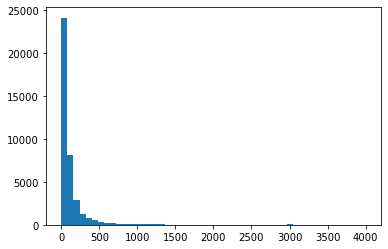

In [18]:
plt.hist(y_train, bins = 50)
plt.show()

## LGBM with log transformed target and Median objective function

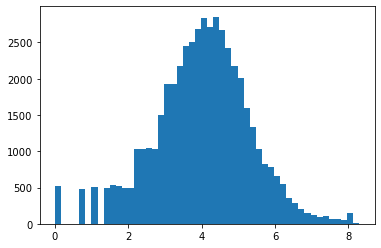

In [12]:
y_log = np.log(y)

plt.hist(y_log, bins = 50)
plt.show()

In [16]:
y_train_log = np.log(y_train)

lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)
lgbm.fit(X_train, y_train_log)

print('LGBM scores: ')

print('Train error: ')
y_log_pred_train = lgbm.predict(X_train)
y_preds_train = np.exp(y_log_pred_train)

mae = mean_absolute_error(y_train, y_preds_train)
print("Mean absolute error: %0.3f" % mae)

print('Test error: ')

y_log_pred_valid = lgbm.predict(X_valid)
y_preds_valid = np.exp(y_log_pred_valid)

mae = mean_absolute_error(y_valid, y_preds_valid)
print("Mean absolute error: %0.3f" % mae)


LGBM scores: 
Train error: 
Mean absolute error: 47.603
Test error: 
Mean absolute error: 51.274


### Ensembling of lgbm, catboost, xgboost

In [23]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import time

t0 = time.time()

xgbr = XGBRegressor(objective = 'reg:linear', random_state = 2020)
xgbr.fit(X_train, y_train)

print(time.time() - t0)
catb = CatBoostRegressor(objective = 'MAE', random_seed = 2020)
catb.fit(X_train, y_train)

print(time.time() - t0)
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)
lgbm.fit(X_train, y_train)

print(time.time() - t0)
y_pred_xg = xgbr.predict(X_valid)
y_pred_lg = lgbm.predict(X_valid)
y_pred_cat = catb.predict(X_valid)

print(time.time() - t0)


[14:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
122.24445867538452
0:	learn: 100.5024109	total: 3.71s	remaining: 1h 1m 42s
1:	learn: 99.9986795	total: 3.97s	remaining: 33m 3s
2:	learn: 99.2780017	total: 4.25s	remaining: 23m 32s
3:	learn: 98.7284281	total: 4.5s	remaining: 18m 40s
4:	learn: 98.1398034	total: 4.73s	remaining: 15m 40s
5:	learn: 97.7390291	total: 4.97s	remaining: 13m 43s
6:	learn: 97.1398028	total: 5.29s	remaining: 12m 30s
7:	learn: 96.7691191	total: 5.59s	remaining: 11m 33s
8:	learn: 96.3121969	total: 5.87s	remaining: 10m 46s
9:	learn: 95.9684009	total: 6.1s	remaining: 10m 3s
10:	learn: 95.5919823	total: 6.34s	remaining: 9m 30s
11:	learn: 95.1467662	total: 6.63s	remaining:

148:	learn: 71.6209823	total: 44.5s	remaining: 4m 14s
149:	learn: 71.5799818	total: 44.7s	remaining: 4m 13s
150:	learn: 71.4923794	total: 44.9s	remaining: 4m 12s
151:	learn: 71.4464800	total: 45.1s	remaining: 4m 11s
152:	learn: 71.4081919	total: 45.4s	remaining: 4m 11s
153:	learn: 71.3725771	total: 45.6s	remaining: 4m 10s
154:	learn: 71.3534086	total: 45.8s	remaining: 4m 9s
155:	learn: 71.2106694	total: 46s	remaining: 4m 9s
156:	learn: 71.1815448	total: 46.3s	remaining: 4m 8s
157:	learn: 71.0932653	total: 46.5s	remaining: 4m 7s
158:	learn: 70.9804256	total: 46.8s	remaining: 4m 7s
159:	learn: 70.9054685	total: 47s	remaining: 4m 6s
160:	learn: 70.7957214	total: 47.2s	remaining: 4m 6s
161:	learn: 70.7011287	total: 47.4s	remaining: 4m 5s
162:	learn: 70.6550679	total: 47.6s	remaining: 4m 4s
163:	learn: 70.6233116	total: 47.8s	remaining: 4m 3s
164:	learn: 70.5829248	total: 48s	remaining: 4m 2s
165:	learn: 70.4941933	total: 48.2s	remaining: 4m 2s
166:	learn: 70.4418174	total: 48.4s	remaining:

302:	learn: 64.3450154	total: 1m 17s	remaining: 2m 59s
303:	learn: 64.3198893	total: 1m 18s	remaining: 2m 58s
304:	learn: 64.2706448	total: 1m 18s	remaining: 2m 58s
305:	learn: 64.2501021	total: 1m 18s	remaining: 2m 58s
306:	learn: 64.2205098	total: 1m 18s	remaining: 2m 57s
307:	learn: 64.1938721	total: 1m 19s	remaining: 2m 57s
308:	learn: 64.1454146	total: 1m 19s	remaining: 2m 57s
309:	learn: 64.1036762	total: 1m 19s	remaining: 2m 57s
310:	learn: 64.0739973	total: 1m 19s	remaining: 2m 56s
311:	learn: 64.0403225	total: 1m 20s	remaining: 2m 56s
312:	learn: 63.9688143	total: 1m 20s	remaining: 2m 56s
313:	learn: 63.9370389	total: 1m 20s	remaining: 2m 55s
314:	learn: 63.8889396	total: 1m 20s	remaining: 2m 55s
315:	learn: 63.8713843	total: 1m 20s	remaining: 2m 54s
316:	learn: 63.8305691	total: 1m 21s	remaining: 2m 54s
317:	learn: 63.8121047	total: 1m 21s	remaining: 2m 54s
318:	learn: 63.7964019	total: 1m 21s	remaining: 2m 54s
319:	learn: 63.7424197	total: 1m 21s	remaining: 2m 53s
320:	learn

452:	learn: 59.6191251	total: 2m 13s	remaining: 2m 41s
453:	learn: 59.6047637	total: 2m 13s	remaining: 2m 41s
454:	learn: 59.5568166	total: 2m 14s	remaining: 2m 40s
455:	learn: 59.5336201	total: 2m 14s	remaining: 2m 40s
456:	learn: 59.5194185	total: 2m 14s	remaining: 2m 40s
457:	learn: 59.4746816	total: 2m 15s	remaining: 2m 39s
458:	learn: 59.4458031	total: 2m 15s	remaining: 2m 39s
459:	learn: 59.4280649	total: 2m 15s	remaining: 2m 39s
460:	learn: 59.4055501	total: 2m 16s	remaining: 2m 39s
461:	learn: 59.3780558	total: 2m 16s	remaining: 2m 38s
462:	learn: 59.3587963	total: 2m 16s	remaining: 2m 38s
463:	learn: 59.3354912	total: 2m 17s	remaining: 2m 38s
464:	learn: 59.3110863	total: 2m 17s	remaining: 2m 38s
465:	learn: 59.2666278	total: 2m 17s	remaining: 2m 37s
466:	learn: 59.2364943	total: 2m 18s	remaining: 2m 37s
467:	learn: 59.2149797	total: 2m 18s	remaining: 2m 37s
468:	learn: 59.2004250	total: 2m 19s	remaining: 2m 37s
469:	learn: 59.1654090	total: 2m 19s	remaining: 2m 37s
470:	learn

602:	learn: 56.0855587	total: 2m 58s	remaining: 1m 57s
603:	learn: 56.0340892	total: 2m 58s	remaining: 1m 56s
604:	learn: 56.0071877	total: 2m 58s	remaining: 1m 56s
605:	learn: 55.9845362	total: 2m 58s	remaining: 1m 56s
606:	learn: 55.9621711	total: 2m 58s	remaining: 1m 55s
607:	learn: 55.9449642	total: 2m 59s	remaining: 1m 55s
608:	learn: 55.9242296	total: 2m 59s	remaining: 1m 55s
609:	learn: 55.9040323	total: 2m 59s	remaining: 1m 54s
610:	learn: 55.8748175	total: 2m 59s	remaining: 1m 54s
611:	learn: 55.8449745	total: 2m 59s	remaining: 1m 54s
612:	learn: 55.8301117	total: 3m	remaining: 1m 53s
613:	learn: 55.8171215	total: 3m	remaining: 1m 53s
614:	learn: 55.8032377	total: 3m	remaining: 1m 53s
615:	learn: 55.7922955	total: 3m	remaining: 1m 52s
616:	learn: 55.7744778	total: 3m 1s	remaining: 1m 52s
617:	learn: 55.7510058	total: 3m 1s	remaining: 1m 52s
618:	learn: 55.7277727	total: 3m 1s	remaining: 1m 51s
619:	learn: 55.7001813	total: 3m 1s	remaining: 1m 51s
620:	learn: 55.6765625	total: 

752:	learn: 53.0708532	total: 3m 40s	remaining: 1m 12s
753:	learn: 53.0613466	total: 3m 40s	remaining: 1m 12s
754:	learn: 53.0516311	total: 3m 41s	remaining: 1m 11s
755:	learn: 52.9999407	total: 3m 41s	remaining: 1m 11s
756:	learn: 52.9766154	total: 3m 41s	remaining: 1m 11s
757:	learn: 52.9530885	total: 3m 41s	remaining: 1m 10s
758:	learn: 52.9444329	total: 3m 42s	remaining: 1m 10s
759:	learn: 52.9284831	total: 3m 42s	remaining: 1m 10s
760:	learn: 52.9035881	total: 3m 42s	remaining: 1m 9s
761:	learn: 52.8910493	total: 3m 42s	remaining: 1m 9s
762:	learn: 52.8712777	total: 3m 42s	remaining: 1m 9s
763:	learn: 52.8417665	total: 3m 43s	remaining: 1m 8s
764:	learn: 52.8281363	total: 3m 43s	remaining: 1m 8s
765:	learn: 52.8110650	total: 3m 43s	remaining: 1m 8s
766:	learn: 52.8026322	total: 3m 43s	remaining: 1m 8s
767:	learn: 52.7887189	total: 3m 44s	remaining: 1m 7s
768:	learn: 52.7676097	total: 3m 44s	remaining: 1m 7s
769:	learn: 52.7472644	total: 3m 44s	remaining: 1m 7s
770:	learn: 52.74094

906:	learn: 50.4508010	total: 4m 17s	remaining: 26.4s
907:	learn: 50.4411171	total: 4m 17s	remaining: 26.1s
908:	learn: 50.4275331	total: 4m 18s	remaining: 25.8s
909:	learn: 50.4054531	total: 4m 18s	remaining: 25.5s
910:	learn: 50.3800186	total: 4m 18s	remaining: 25.3s
911:	learn: 50.3661351	total: 4m 18s	remaining: 25s
912:	learn: 50.3485375	total: 4m 18s	remaining: 24.7s
913:	learn: 50.3335279	total: 4m 19s	remaining: 24.4s
914:	learn: 50.3166763	total: 4m 19s	remaining: 24.1s
915:	learn: 50.3024186	total: 4m 19s	remaining: 23.8s
916:	learn: 50.2922777	total: 4m 19s	remaining: 23.5s
917:	learn: 50.2851647	total: 4m 19s	remaining: 23.2s
918:	learn: 50.2613528	total: 4m 20s	remaining: 22.9s
919:	learn: 50.2417825	total: 4m 20s	remaining: 22.6s
920:	learn: 50.2277676	total: 4m 20s	remaining: 22.3s
921:	learn: 50.2145715	total: 4m 20s	remaining: 22.1s
922:	learn: 50.2036763	total: 4m 20s	remaining: 21.8s
923:	learn: 50.1909009	total: 4m 21s	remaining: 21.5s
924:	learn: 50.1773933	total: 

IndexError: tuple index out of range

In [57]:
y_preds = pd.DataFrame({'xg' : y_pred_xg,
                        'lg' : y_pred_lg,
                        'cat' : y_pred_cat})

y_preds_valid = np.max(y_preds, axis = 1)

y_preds_valid.shape

(9898,)

In [58]:
y_preds_valid[y_preds_valid < 0].shape

(47,)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


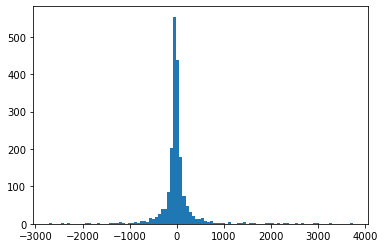

In [59]:
plt.hist(y_valid - y_preds_valid, bins = 100)
plt.show()

In [55]:
np.min(y_valid - y_preds_valid)

-2373.7916593452496

In [60]:
mae = mean_absolute_error(y_valid, y_preds_valid)
print("Mean absolute error: %0.3f" % mae)


Mean absolute error: 45.330
